In [11]:
from qiskit import QuantumCircuit, transpile
from qiskit.circuit.library import UnitaryGate
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import sin, asin, floor, sqrt, pi
import numpy as np
from scipy.linalg import sqrtm, fractional_matrix_power
from qiskit.circuit.library import CRXGate



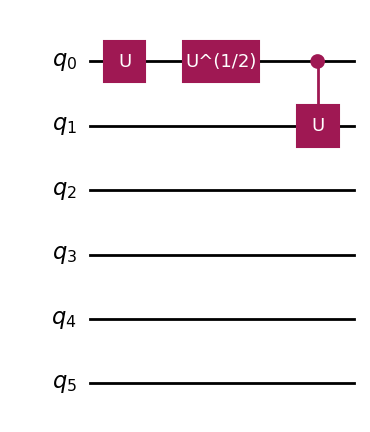

In [8]:
U = np.array([
    [1, 0],
    [0, -1]
])

U_sqrt = sqrtm(U)

u_gate = UnitaryGate(U, label="U")
u_sqrt_gate = UnitaryGate(U_sqrt, label="U^(1/2)")
cu_gate = u_gate.control(1)

# Custom color style
style = {
    "displaycolor": {"U": ("#168A2F", "#000000")}  # (gate fill color, text color)
}


qc = QuantumCircuit(6, name="circuit")
qc.append(u_gate, [0])
qc.append(u_sqrt_gate, [0])
qc.append(cu_gate, [0, 1])
qc.draw(output="mpl")

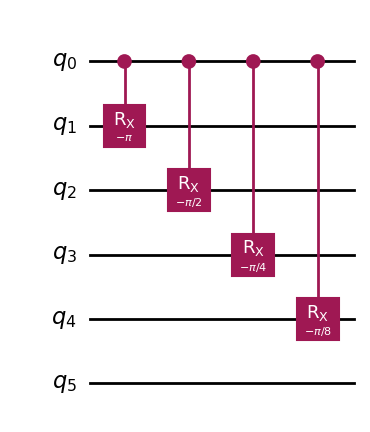

In [46]:
def c_phase_sqrt_u(n: int, m: int, U):
    ans = QuantumCircuit(m + 2)
    if m == n - 1:
        for j in range(m):
            ans.append(CRXGate(pi/(2**(j))), [0, j + 1])
            
        cu_gate = UnitaryGate(U, label=f"U^(2^-{m})").control(1)
        ans.append(cu_gate, [0, m + 1])
    else:
        for j in range(m):
            ans.append(CRXGate(pi/(2**(j + 1))), [0, j + 1])

        cu_gate = UnitaryGate(U, label=f"U^(2^-{m + 1})").control(1)
        ans.append(cu_gate, [0, m + 1])

    return ans

def c_phase_sqrt_u_dagger(n: int, m: int, U):
    ans = QuantumCircuit(m + 2)
    U = U.conj().T
    for j in range(m):
        ans.append(CRXGate(pi/(2**(j + 1))), [0, j + 1])

    cu_gate = UnitaryGate(U, label=f"U_dagger^(2^-{m + 1})").control(1)
    ans.append(cu_gate, [0, m + 1])
        
    return ans

def c_phase(n: int, m: int):
    ans = QuantumCircuit(m + 2)
    for j in range(m):
        ans.append(CRXGate(pi/(2**(j + 1))), [0, j + 1])

    return ans

def c_phase_dagger(n: int, m: int):
    ans = QuantumCircuit(m + 2)
    if m == n - 1:
        for j in range(m):
            ans.append(CRXGate(-pi/(2**(j))), [0, j + 1])
    else:
        for j in range(m):
            ans.append(CRXGate(-pi/(2**(j + 1))), [0, j + 1])

    return ans

U = np.array([
    [1, 0],
    [0, -1]
])
c_phase_dagger(5, 4).draw(output="mpl", style=style)

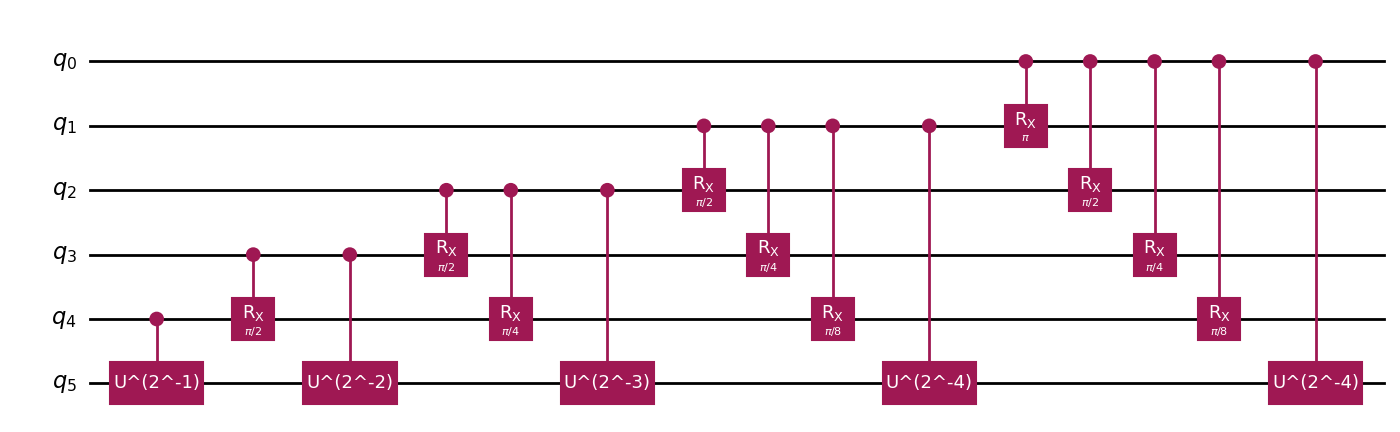

In [53]:
def mcu(n: int, U):
    ans = QuantumCircuit(n + 1)
    for m in range(n):
        ans.append(c_phase_sqrt_u(n, m, U), range(n - m - 1, n + 1))

    return ans

U = np.array([
    [1, 0],
    [0, -1]
])

mcu(5, U).decompose().draw(output="mpl", style=style)